# Libraries

In [1]:
!pip install zarr
!pip install pystac
!pip install xarray[complete]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 980.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=3bd15e842b3017875ab3772c02bc418a780e8121fec8c49c6d728753b8092c03
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 991.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 k

In [2]:
#Importing the necessary libraries
import pandas as pd
import pystac
import fsspec
import xarray as xr
import datetime 
import numpy as np
import math
from tqdm import tqdm
from datetime import date
import pystac
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import warnings
import os
import random

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 300)

/opt/conda/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


# Data Processing

In [3]:
def seed_everything(seed=2022):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=2022)

In [4]:
columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
continent_names = {
    'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
    'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
    'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
    'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
}

In [5]:
train = pd.read_csv("ey-bwwdc-level-3/occurrence.txt", sep='\t', parse_dates=['eventDate']).assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )[columns]

train.dropna(inplace=True)
train["occurrenceStatus"] = "PRESENT"

req_cols = ['eventDate', 'decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"]
train = train[req_cols]

df_frog = train.copy()

In [6]:
terra_aus = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_sa = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_cr = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_test = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test.csv")

terra_test_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2005to2007.csv")
terra_test_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2007to2009.csv")
terra_test_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2009to2011.csv")

terra_test_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2011to2013.csv")
terra_test_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2013to2015.csv")
terra_test_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2015to2017.csv")

In [7]:
terra_test_2005 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2005, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2007 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2007, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2009 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2009, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')


terra_test_2011 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2011, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2013 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2013, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2015 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2015, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')

## Preparing Australia Dataset

In [8]:
terra_aus_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2005to2007_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2007to2009_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2009to2011_Terraclimate_aus_grid_bbox_25sqkm.csv")

terra_aus_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2011to2013_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2013to2015_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2015to2017_Terraclimate_aus_grid_bbox_25sqkm.csv")

terra_aus_2005.fillna(terra_aus_2005.median(), inplace=True)
terra_aus_2007.fillna(terra_aus_2007.median(), inplace=True)
terra_aus_2009.fillna(terra_aus_2009.median(), inplace=True)

terra_aus_2011.fillna(terra_aus_2011.median(), inplace=True)
terra_aus_2013.fillna(terra_aus_2013.median(), inplace=True)
terra_aus_2015.fillna(terra_aus_2015.median(), inplace=True)

aus_alldate_terra = terra_aus.append(terra_aus_2011)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2013)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2015)

aus_alldate_terra = aus_alldate_terra.append(terra_aus_2005)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2007)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2009)

train_data_aus = aus_alldate_terra

feat_cols = train_data_aus.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

aus_train = train_data_aus[feat_cols]

upper = 500
print("Size Before Filter :", aus_train.shape)
aus_train = aus_train[(aus_train['frog_count'] <= upper)]
print("Size After Filter :", aus_train.shape)

aus_train.fillna(aus_train.median(), inplace=True)

Size Before Filter : (72394, 14)
Size After Filter : (72296, 14)


## Preparing South Africa Dataset

In [9]:
terra_sa_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2005to2007_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2007to2009_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2009to2011_Terraclimate_sa_grid_bbox_25sqkm.csv")

terra_sa_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2011to2013_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2013to2015_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2015to2017_Terraclimate_sa_grid_bbox_25sqkm.csv")

terra_sa_2005.fillna(terra_sa_2005.median(), inplace=True)
terra_sa_2007.fillna(terra_sa_2007.median(), inplace=True)
terra_sa_2009.fillna(terra_sa_2009.median(), inplace=True)

terra_sa_2011.fillna(terra_sa_2011.median(), inplace=True)
terra_sa_2013.fillna(terra_sa_2013.median(), inplace=True)
terra_sa_2015.fillna(terra_sa_2015.median(), inplace=True)

sa_alldate_terra = terra_sa.append(terra_sa_2011)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2013)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2015)

sa_alldate_terra = sa_alldate_terra.append(terra_sa_2005)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2007)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2009)

train_data_sa = sa_alldate_terra

feat_cols = train_data_sa.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

sa_train = train_data_sa[feat_cols]


upper = 500
print("Size Before Filter :", sa_train.shape)
sa_train = sa_train[(sa_train['frog_count'] <= upper)]
print("Size After Filter :", sa_train.shape)

sa_train.fillna(sa_train.median(), inplace=True)

Size Before Filter : (4690, 14)
Size After Filter : (4690, 14)


## Preparing Costa Rica Dataset

In [10]:
terra_cr_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2005to2007_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2007to2009_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2009to2011_Terraclimate_cr_grid_bbox_25sqkm.csv")

terra_cr_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2011to2013_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2013to2015_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2015to2017_Terraclimate_cr_grid_bbox_25sqkm.csv")

terra_cr_2005.fillna(terra_cr_2005.median(), inplace=True)
terra_cr_2007.fillna(terra_cr_2007.median(), inplace=True)
terra_cr_2009.fillna(terra_cr_2009.median(), inplace=True)

terra_cr_2011.fillna(terra_cr_2011.median(), inplace=True)
terra_cr_2013.fillna(terra_cr_2013.median(), inplace=True)
terra_cr_2015.fillna(terra_cr_2015.median(), inplace=True)

cr_alldate_terra = terra_cr.append(terra_cr_2011)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2013)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2015)

cr_alldate_terra = cr_alldate_terra.append(terra_cr_2005)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2007)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2009)

train_data_cr = cr_alldate_terra

feat_cols = train_data_cr.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

cr_train = train_data_cr[feat_cols]

upper = 100
print("Size Before Filter :", cr_train.shape)
cr_train = cr_train[(cr_train['frog_count'] <= upper)]
print("Size After Filter :", cr_train.shape)

cr_train.fillna(cr_train.median(), inplace=True)

Size Before Filter : (3815, 14)
Size After Filter : (3808, 14)


## Feature Engineering (Simplified)

In [11]:
aus_train["vap_vpd_diff"] = aus_train["vap"] - aus_train["vpd"]
sa_train["vap_vpd_diff"] = sa_train["vap"] - sa_train["vpd"]
cr_train["vap_vpd_diff"] = cr_train["vap"] - cr_train["vpd"]

aus_train["tmax_tmin_diff"] = aus_train["tmax"] - aus_train["tmin"]
sa_train["tmax_tmin_diff"] = sa_train["tmax"] - sa_train["tmin"]
cr_train["tmax_tmin_diff"] = cr_train["tmax"] - cr_train["tmin"]

aus_train.reset_index(drop=True, inplace=True)
sa_train.reset_index(drop=True, inplace=True)
cr_train.reset_index(drop=True, inplace=True)

## Cross Validation

In [12]:
fold_store = {
    "fold_0":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_1":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_2":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_3":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_4":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
}

In [13]:
from sklearn.model_selection import KFold

skf = KFold(n_splits=5, shuffle=True, random_state=2022)
for i, (train_index, test_index) in enumerate(skf.split(aus_train.loc[:,[i for i in aus_train.columns if i != "frog_count"]], aus_train["frog_count"])):
    fold_store[f'fold_{i}']["aus"].append(train_index)
    fold_store[f'fold_{i}']["aus"].append(test_index)
    
skf = KFold(n_splits=5, shuffle=True, random_state=2022)
for i, (train_index, test_index) in enumerate(skf.split(sa_train.loc[:,[i for i in sa_train.columns if i != "frog_count"]], sa_train["frog_count"])):
    fold_store[f'fold_{i}']["sa"].append(train_index)
    fold_store[f'fold_{i}']["sa"].append(test_index)
    
skf = KFold(n_splits=5, shuffle=True, random_state=2022)
for i, (train_index, test_index) in enumerate(skf.split(cr_train.loc[:,[i for i in cr_train.columns if i != "frog_count"]], cr_train["frog_count"])):
    fold_store[f'fold_{i}']["cr"].append(train_index)
    fold_store[f'fold_{i}']["cr"].append(test_index)

Starting Fold 0
(64634, 15)
(16160, 15)


2022-06-04 10:50:34.188562: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Training Model ...
Epoch 1/10000


2022-06-04 10:50:34.409782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


505/505 [==============================] - 4s 6ms/step - loss: 11.1091 - val_loss: 11.0493
Epoch 2/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.7686 - val_loss: 10.9846
Epoch 3/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.5928 - val_loss: 10.6776
Epoch 4/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.4702 - val_loss: 10.6589
Epoch 5/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.4166 - val_loss: 10.4573
Epoch 6/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.3094 - val_loss: 10.5265
Epoch 7/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.2533 - val_loss: 10.3694
Epoch 8/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.1799 - val_loss: 10.2724
Epoch 9/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.1932 - val_loss: 10.3198
Epoch 10/10000
505/505 [==============================] - 3s 5ms/step

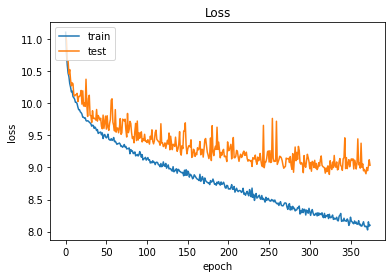

[Text(0.5, 1.0, 'Predicted Frog Count Distribution')]
MAE : 8.884591584158416
MSE : 714.0487004950495
R^2 : 0.39546715464872984

CV Mean : 13.016955445544555
CV WMAPE 0.6825399089154472


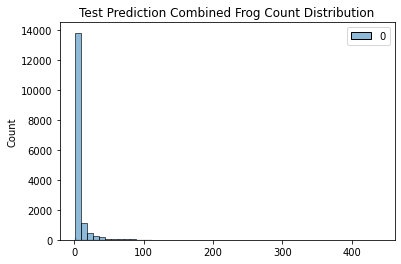

Ending Fold 0

Starting Fold 1
(64635, 15)
(16159, 15)
Training Model ...
Epoch 1/10000
505/505 [==============================] - 4s 6ms/step - loss: 11.1393 - val_loss: 10.4855
Epoch 2/10000
505/505 [==============================] - 3s 7ms/step - loss: 10.7966 - val_loss: 10.2437
Epoch 3/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.6564 - val_loss: 10.2907
Epoch 4/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.6089 - val_loss: 10.1582
Epoch 5/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.5616 - val_loss: 10.0874
Epoch 6/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.4039 - val_loss: 9.9803
Epoch 7/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.3824 - val_loss: 9.9831
Epoch 8/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.3196 - val_loss: 9.8615
Epoch 9/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.3153 - va

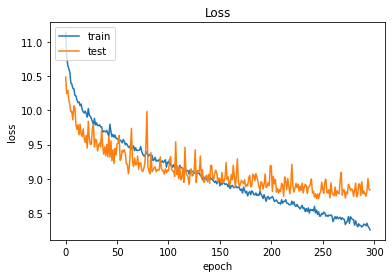

[Text(0.5, 1.0, 'Predicted Frog Count Distribution')]
MAE : 8.705736741134972
MSE : 650.2393712482208
R^2 : 0.37560880126912677

CV Mean : 12.549353301565692
CV WMAPE 0.6937199497004216


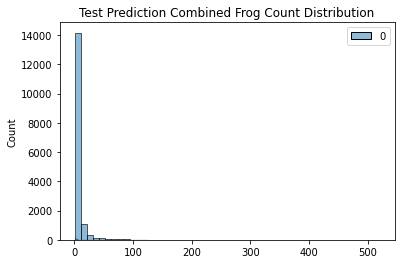

Ending Fold 1

Starting Fold 2
(64635, 15)
(16159, 15)
Training Model ...
Epoch 1/10000
505/505 [==============================] - 4s 6ms/step - loss: 10.9766 - val_loss: 11.6712
Epoch 2/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.5959 - val_loss: 11.2179
Epoch 3/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.5032 - val_loss: 11.0621
Epoch 4/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.3823 - val_loss: 11.2164
Epoch 5/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.3043 - val_loss: 11.0749
Epoch 6/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.2531 - val_loss: 10.7480
Epoch 7/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.2653 - val_loss: 10.8725
Epoch 8/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.1699 - val_loss: 10.6447
Epoch 9/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.1195 -

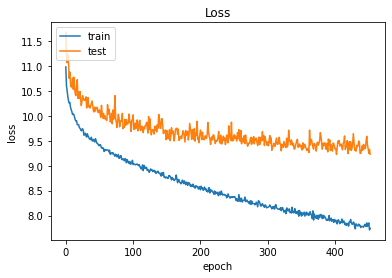

[Text(0.5, 1.0, 'Predicted Frog Count Distribution')]
MAE : 9.218392227241784
MSE : 701.9570517977597
R^2 : 0.41541029084474534

CV Mean : 13.487406398910824
CV WMAPE 0.6834814607489114


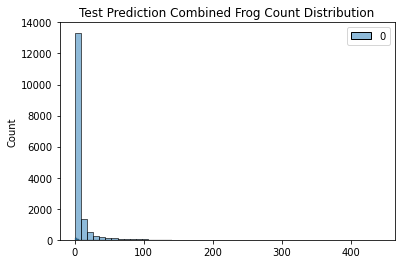

Ending Fold 2

Starting Fold 3
(64636, 15)
(16158, 15)
Training Model ...
Epoch 1/10000
505/505 [==============================] - 3s 5ms/step - loss: 11.1845 - val_loss: 10.4910
Epoch 2/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.8375 - val_loss: 10.2368
Epoch 3/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.7228 - val_loss: 10.5375
Epoch 4/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.6343 - val_loss: 10.1269
Epoch 5/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.5216 - val_loss: 9.9597
Epoch 6/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.4124 - val_loss: 10.0402
Epoch 7/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.3612 - val_loss: 9.8290
Epoch 8/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.3062 - val_loss: 9.7915
Epoch 9/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.2806 - va

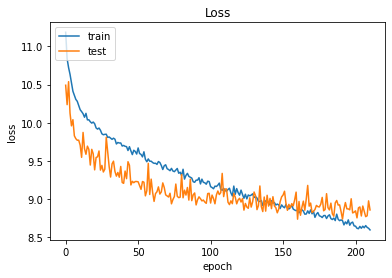

[Text(0.5, 1.0, 'Predicted Frog Count Distribution')]
MAE : 8.731092957049139
MSE : 649.9188637207575
R^2 : 0.3733431267301426

CV Mean : 12.468374798861245
CV WMAPE 0.70025910336338


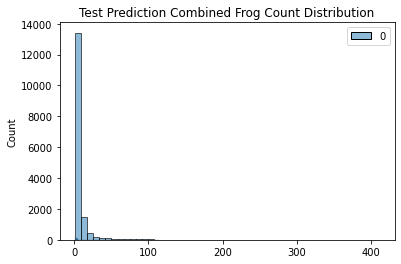

Ending Fold 3

Starting Fold 4
(64636, 15)
(16158, 15)
Training Model ...
Epoch 1/10000
505/505 [==============================] - 3s 5ms/step - loss: 11.2597 - val_loss: 11.0176
Epoch 2/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.9752 - val_loss: 10.7736
Epoch 3/10000
505/505 [==============================] - 2s 5ms/step - loss: 10.7543 - val_loss: 10.6168
Epoch 4/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.6538 - val_loss: 10.5276
Epoch 5/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.5883 - val_loss: 10.4623
Epoch 6/10000
505/505 [==============================] - 4s 8ms/step - loss: 10.5385 - val_loss: 10.4246
Epoch 7/10000
505/505 [==============================] - 3s 6ms/step - loss: 10.4501 - val_loss: 10.3677
Epoch 8/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.4012 - val_loss: 10.4048
Epoch 9/10000
505/505 [==============================] - 3s 5ms/step - loss: 10.3362 -

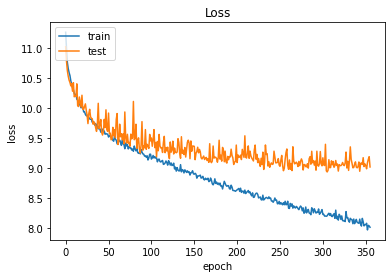

[Text(0.5, 1.0, 'Predicted Frog Count Distribution')]
MAE : 8.928765936378264
MSE : 702.7866691422206
R^2 : 0.37942705256409437

CV Mean : 12.82330734001733
CV WMAPE 0.6962919705210932


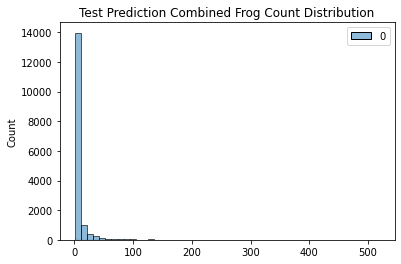

Ending Fold 4



In [14]:
for val in range(0, 5):
    print(f"Starting Fold {val}")
    print("===========================")
    X_train_aus, y_train_aus = aus_train.loc[fold_store[f"fold_{val}"]["aus"][0], [i for i in aus_train.columns if i != "frog_count"]], aus_train.loc[fold_store[f"fold_{val}"]["aus"][0], "frog_count"]
    X_test_aus, y_test_aus = aus_train.loc[fold_store[f"fold_{val}"]["aus"][1], [i for i in aus_train.columns if i != "frog_count"]], aus_train.loc[fold_store[f"fold_{val}"]["aus"][1], "frog_count"]
    
    X_train_sa, y_train_sa = sa_train.loc[fold_store[f"fold_{val}"]["sa"][0], [i for i in sa_train.columns if i != "frog_count"]], sa_train.loc[fold_store[f"fold_{val}"]["sa"][0], "frog_count"]
    X_test_sa, y_test_sa = sa_train.loc[fold_store[f"fold_{val}"]["sa"][1], [i for i in sa_train.columns if i != "frog_count"]], sa_train.loc[fold_store[f"fold_{val}"]["sa"][1], "frog_count"]
    
    X_train_cr, y_train_cr = cr_train.loc[fold_store[f"fold_{val}"]["cr"][0], [i for i in cr_train.columns if i != "frog_count"]], cr_train.loc[fold_store[f"fold_{val}"]["cr"][0], "frog_count"]
    X_test_cr, y_test_cr = cr_train.loc[fold_store[f"fold_{val}"]["cr"][1], [i for i in cr_train.columns if i != "frog_count"]], cr_train.loc[fold_store[f"fold_{val}"]["cr"][1], "frog_count"]
    
    X_train = X_train_aus.append(X_train_sa)
    X_train = X_train.append(X_train_cr)

    X_test = X_test_aus.append(X_test_sa)
    X_test = X_test.append(X_test_cr)

    y_train = y_train_aus.append(y_train_sa)
    y_train = y_train.append(y_train_cr)

    y_test = y_test_aus.append(y_test_sa)
    y_test = y_test.append(y_test_cr)
    print(X_train.shape)
    print(X_test.shape)
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    from sklearn.preprocessing import MinMaxScaler

    
    # Data normalization using Minmaxscaler
    mm_scaler = MinMaxScaler()
    X_train_mm = mm_scaler.fit_transform(X_train)
    X_test_mm = mm_scaler.transform(X_test)


    # Model checkpoint
    checkpoint = ModelCheckpoint(filepath=f'aus_terra_2005_to_present_fold{val}.pkl',
                                 monitor='val_loss',verbose=0,save_weights_only=True,save_best_only=True,mode='min')

    # model architecture for ANN model
    model = Sequential()
    # model.add(Dense(512, activation="relu", input_dim=len(X_train_mm[0])))
    model.add(Dense(256, activation="relu", input_dim=len(X_train_mm[0])))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation="linear"))


    # model.compile(loss='mean_absolute_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))
    model.compile(optimizer = "adam", loss = 'mean_absolute_error')

    # Patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    print("Training Model ...")
    # Fitting the model on train data
    history = model.fit(X_train_mm, y_train, validation_data=(X_test_mm, y_test), epochs=10000, batch_size=128,
                        verbose=1, callbacks=[es,checkpoint])
    print("Training Complete ...")
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    model.load_weights(f"./aus_terra_2005_to_present_fold{val}.pkl")
    preds_ = model.predict(X_test_mm)
    print(sns.histplot(preds_, bins=50).set(title='Predicted Frog Count Distribution'))
    pred_df = pd.DataFrame()
    pred_df["preds"] = [i[0] for i in preds_]
    pred_df.to_csv(f"fold_{val}_cv_predictions.csv", index=False)
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    from sklearn.metrics import r2_score
    print("MAE :", mean_absolute_error(y_test, preds_.round()))
    print("MSE :", mean_squared_error(y_test, preds_.round()))
    print("R^2 :", r2_score(y_test, preds_))
    print()
    print("CV Mean :", y_test.mean())
    print("CV WMAPE" , mean_absolute_error(y_test, preds_.round()) / y_test.mean())
    
    
    def generate_test_preds(terra_test, model_ckpt):
        test_data = terra_test
        test_feat_cols = test_data.columns[6:].tolist()
        remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep', 'Predicted_frog_count_x', 'Predicted_frog_count_y', 'Predicted_frog_count', 'Id', 'coord', 'frog_count']
        test_feat_cols = [i for i in test_feat_cols if i not in remove_cols]
        test_ = test_data[test_feat_cols]
        test_ = test_.fillna(test_.median())
        test_["vap_vpd_diff"] = test_["vap"] - test_["vpd"]
        test_["tmax_tmin_diff"] = test_["tmax"] - test_["tmin"]
        aus_test_minmax = mm_scaler.fit_transform(test_)
        model.load_weights(model_ckpt)
        test_pred_aus = model.predict(aus_test_minmax)
        return test_pred_aus

    test_pred_aus_2017 = generate_test_preds(terra_test, f"./aus_terra_2005_to_present_fold{val}.pkl")
    test_pred_aus_2015 = generate_test_preds(terra_test_2015, f"./aus_terra_2005_to_present_fold{val}.pkl")
    test_pred_aus_2013 = generate_test_preds(terra_test_2013, f"./aus_terra_2005_to_present_fold{val}.pkl")
    test_pred_aus_2011 = generate_test_preds(terra_test_2011, f"./aus_terra_2005_to_present_fold{val}.pkl")
    

    test_preds_2011 = [i[0] for i in test_pred_aus_2011]
    test_preds_2013 = [i[0] for i in test_pred_aus_2013]
    test_preds_2015 = [i[0] for i in test_pred_aus_2015]
    test_preds_2017 = [i[0] for i in test_pred_aus_2017]

    test_pred = []
    for i in range(len(test_preds_2011)):
        test_pred.append((test_preds_2011[i] + test_preds_2013[i] + test_preds_2015[i] + test_preds_2017[i]
                         ) / 4)

    sns.histplot(test_pred,bins=50).set(title='Test Prediction Combined Frog Count Distribution')
    plt.show()

    submission = pd.read_csv(r"ey-bwwdc-level-3/level_3_test_data.csv")
    submission["Predicted_frog_count"] = test_pred
    submission["Predicted_frog_count"] = submission["Predicted_frog_count"].round()
    submission.to_csv(fr"ANN_Terra_2017to2019_11year_test_evaluatedon2011-2019_25sqkm_feat_eng(2)_rmsle_fold{val}.csv", index=False)
    
    print("===========================")
    print(f"Ending Fold {val}")
    print()

In [15]:
results_df = pd.DataFrame()

for fold in range(5):
    def generate_test_preds(terra_test, model_ckpt):
        test_data = terra_test
        test_feat_cols = test_data.columns[6:].tolist()
        remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep', 'Predicted_frog_count_x', 'Predicted_frog_count_y', 'Predicted_frog_count', 'Id', 'coord', 'frog_count']
        test_feat_cols = [i for i in test_feat_cols if i not in remove_cols]
        test_ = test_data[test_feat_cols]
        test_ = test_.fillna(test_.median())
        test_["vap_vpd_diff"] = test_["vap"] - test_["vpd"]
        test_["tmax_tmin_diff"] = test_["tmax"] - test_["tmin"]
        aus_test_minmax = mm_scaler.fit_transform(test_)
        model.load_weights(model_ckpt)
        test_pred_aus = model.predict(aus_test_minmax)
        return test_pred_aus

    test_pred_aus_2017 = generate_test_preds(terra_test, f"./aus_terra_2005_to_present_fold{fold}.pkl")
    test_pred_aus_2015 = generate_test_preds(terra_test_2015, f"./aus_terra_2005_to_present_fold{fold}.pkl")
    test_pred_aus_2013 = generate_test_preds(terra_test_2013, f"./aus_terra_2005_to_present_fold{fold}.pkl")
    test_pred_aus_2011 = generate_test_preds(terra_test_2011, f"./aus_terra_2005_to_present_fold{fold}.pkl")


    test_preds_2011 = [i[0] for i in test_pred_aus_2011]
    test_preds_2013 = [i[0] for i in test_pred_aus_2013]
    test_preds_2015 = [i[0] for i in test_pred_aus_2015]
    test_preds_2017 = [i[0] for i in test_pred_aus_2017]

    test_pred = []
    for i in range(len(test_preds_2011)):
        test_pred.append((test_preds_2011[i] + test_preds_2013[i] + test_preds_2015[i] + test_preds_2017[i]
                     ) / 4)
        
    results_df[f"fold_{fold}"] = test_pred

In [16]:
results_df["mean_preds"] = ((results_df['fold_0'] + results_df['fold_1'] + results_df['fold_2'] + results_df['fold_3'] + results_df['fold_4']) / 5).round()

In [17]:
submission = pd.read_csv(r"ey-bwwdc-level-3/level_3_test_data.csv")
submission["Predicted_frog_count"] = results_df["mean_preds"]
submission.to_csv(r"Final_Sub_ANN_MAE_trainon_05to19_evalon_17to19.csv", index=False)

In [18]:
submission

,Id,min_lon,min_lat,max_lon,max_lat,Predicted_frog_count
0,1,133.9014,-27.1322,134.1738,-26.8813,1.0
1,2,134.1738,-32.9015,134.4463,-32.6506,4.0
2,3,134.9912,-32.9015,135.2637,-32.6506,1.0
3,4,135.2637,-34.6574,135.5361,-34.4065,5.0
4,5,135.2637,-34.1557,135.5361,-33.9048,10.0
...,...,...,...,...,...,...
177,178,-83.1555,8.2442,-82.8831,8.4950,1.0
178,179,-83.1555,8.4950,-82.8831,8.7458,1.0
179,180,-83.1555,8.7458,-82.8831,8.9967,1.0
180,181,-82.8831,8.4950,-82.6106,8.7458,1.0


In [19]:
submission.tail(40)

,Id,min_lon,min_lat,max_lon,max_lat,Predicted_frog_count
142,143,22.2671,-33.4611,22.5396,-33.2102,1.0
143,144,22.2671,-32.4577,22.5396,-32.2069,1.0
144,145,22.5396,-34.2136,22.8120,-33.9627,2.0
145,146,22.5396,-33.4611,22.8120,-33.2102,2.0
146,147,22.8120,-34.2136,23.0845,-33.9627,2.0
147,148,22.8120,-33.9627,23.0845,-33.7119,2.0
148,149,23.0845,-34.2136,23.3569,-33.9627,1.0
149,150,23.0845,-33.9627,23.3569,-33.7119,1.0
150,151,23.3569,-34.2136,23.6294,-33.9627,1.0
151,152,23.3569,-33.9627,23.6294,-33.7119,2.0


In [20]:
submission.head(40)

,Id,min_lon,min_lat,max_lon,max_lat,Predicted_frog_count
0,1,133.9014,-27.1322,134.1738,-26.8813,1.0
1,2,134.1738,-32.9015,134.4463,-32.6506,4.0
2,3,134.9912,-32.9015,135.2637,-32.6506,1.0
3,4,135.2637,-34.6574,135.5361,-34.4065,5.0
4,5,135.2637,-34.1557,135.5361,-33.9048,10.0
5,6,135.8086,-34.9082,136.0811,-34.6574,5.0
6,7,136.6260,-36.1624,136.8984,-35.9116,7.0
7,8,136.8984,-35.9116,137.1709,-35.6607,10.0
8,9,137.4434,-35.9116,137.7158,-35.6607,4.0
9,10,137.4434,-35.6607,137.7158,-35.4099,4.0
